<center>

# Real Time Bus Number Detection using Tensorflow and Keras

</center>

<hr/>



<center>

#Table of contents:

###1.   [Project approach explained](#scrollTo=2yZ6eNWEKSws)
###2.   [Google colab setup (Optional)](#scrollTo=udrfzEjwQL_n&line=3&uniqifier=1)
### 3.   [Imports and path set](#scrollTo=kmI5eIakQ6A_)

###4.   [Tensorflow Object api install (if not done)](#scrollTo=9QWx13qxQeFP)
###5.   [Loading the Bus Detector model](#scrollTo=fPxhCUuGSbrh)
###6.   [Loading the Digit Detector model](#scrollTo=ZyoEpSrASsRR)
###7.   [Integrating the models](#scrollTo=EMhGoTj1S7jI)
###8.  [Running the detection model](#scrollTo=WGpL03taTKtV)
###9.   [Hardware specs and performance](#scrollTo=RCE9mfKKXGZ6&line=3&uniqifier=1)
###10.   [Future Improvements](#scrollTo=9cblhZ5PcI7V)
<hr/>


</center>


# Project approach



##**Goal:** Detect and track the bus numbers in a HD video in real-time.

The detection is done two-fold:
1. First detect the buses in the video.
2. Then detect the numbers on those buses.

<hr/>

Benefits of two fold approach compared to direct digit detection:
* There is no robust dataset that has explicitly has bus numbers. This can be trained using publicly available datasets.
* The detection of buses in the first step, drastically reduces the search space for the digit detection (MSCOCO and SVHN).
* As the model is constrained to find digits within the bus, it won't detect any random digits elsewhere in the video.  

<hr/>

#### 1. Detect the buses in the video:
I have used [YOLOv2 tiny](https://pjreddie.com/darknet/yolov2/) model trained on the [MSCOCO datset](http://cocodataset.org/#explore) to detect the buses. The model in the project has been translated from DarkNet to Keras.

#### 2. Detect the digits in the bus:
I have used SSD_MOBILENETv1 architecture and trained it from scratch on the SVHN dataset. I have used the Tensorflow Object Detection API in this part.

<hr>

In [0]:
# Default is Jupyter Notebook not on Colab
GOOGLE_COLAB = False

#Google collab setup (Optional)

If running on Google Colab, uncommment below to mount the drive.
Please note that this will only work if the whole folder is on your drive. Google Colab does not allow public folders yet.
This will allow access to folders stored in Google Drive.


In [0]:

# GOOGLE_COLAB = True
# from google.colab import drive
# drive.mount('/content/drive')
# %reload_ext autoreload
# %autoreload 2
# %tensorflow_version 1.x
# # PATH TO ROOT DIR
# dir_path_main = '/content/drive/My Drive/trail_ready/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Imports and path set

In [0]:

#Add subfolders to sys path to enable imports
import os

if GOOGLE_COLAB == False:
  dir_path_main = os.path.dirname(os.path.abspath(os.listdir()[0]))+'/'

os.sys.path.append(dir_path_main+'Bus_Detection/')
os.sys.path.append(dir_path_main+'Digit_Detection/')

import time
import pathlib
import copy

##Get tensorflow and keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model

##Get matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

%matplotlib inline

#Get helper functions
from utils.yolo_postprocess import yolo_eval , yolo_filter_boxes , yolo_non_max_suppression , load_image_into_numpy_array
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners
from utils.yolo_utils import *
from post_process import add_bus_numbers


## Take in the input file_name
video_file = dir_path_main+'data/Training_3.MOV'

Using TensorFlow backend.


# Install Tensorflow Object Detection api

In [0]:
## Install pycococ tools and clone in tensorflow Object detection api
## We will need the object detection api
!pip install pycocotools
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3380, done.
remote: Counting objects: 100% (3380/3380), done.
remote: Compressing objects: 100% (2870/2870), done.
remote: Total 3380 (delta 655), reused 2051 (delta 432), pack-reused 0
Receiving objects: 100% (3380/3380), 371.08 MiB | 46.63 MiB/s, done.
Resolving deltas: 100% (655/655), done.
Checking out files: 100% (3194/3194), done.


If the following code block does not run, please refer to installation of tensorflow object detection api


In [0]:
## After successfully installing the required dependencies for Tensorflow Object Detection api
## this command should return no error messages
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [0]:
## Install Tensorflow Object Detection api
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017523 sha256=efb58d8049cfadf79f05ce6df6d1fa047d5a27a01fb343e049374b9c1fd23fe8
  Stored in directory: /tmp/pip-ephem-wheel-cache-bc32zz3p/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


In [0]:
# from object_detection.utils import ops as utils_ops

## These are the functions from Tensorflow Object api that we will be using
##  utils.my_draw is a custom made bounding box plotting function, based off the Tensorflow Object Detection api  
from object_detection.utils import label_map_util
import utils.my_draw as my_draw

# Loading Bus Detector Model

In [0]:
#Start Tensorflow session and Load the pre-trained YOLOv2-tiny model
#The class names, labels and anchors are the default ones  
sess1 = K.get_session()
yolo_model = load_model(dir_path_main+'Bus_Detection/'+"model_data/yolov2-tiny.h5", compile=False)
class_names = read_classes(dir_path_main+'Bus_Detection/'+"model_data/yolo_coco_classes.txt")
anchors = read_anchors(dir_path_main+'Bus_Detection/'+"model_data/yolo_anchors.txt")

# Generate colors for drawing bounding boxes.
colors = generate_colors(class_names)

#This function takes the Output of Yolo model and converts it into Bounding Box parameters
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

# Get Image size so that we can initiate the model
# We need this information to upscale the output bounding boxes
vcap = cv2.VideoCapture(video_file)
frame_width = vcap.get(cv2.CAP_PROP_FRAME_WIDTH)
frame_height = vcap.get(cv2.CAP_PROP_FRAME_HEIGHT)
image_shape = np.float32([frame_height,frame_width])

#This function takes the Bounding Bounding Box parameters into Bounding Boxes with labels.
# Scores are how confident the model is about the prediction
# Boxes are the coordinates of the boxes that surround detected objects
# Classes are the labels of those detected objects

scores1, boxes1, classes1 = yolo_eval(yolo_outputs, image_shape=image_shape,score_threshold=.2)













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def bus_detection(sess, image, colors):
  '''
  Input: Tensorflow session, Raw frame from the video , list of colors for the bounding boxes around buses.

  Function:
    1. Find the objects (MSCOCO classes) in the image.
    2. Filter out the non-bus classes/
  
  Output:
    Return the Bounding boxes and the cropped images of the buses found.

  '''
    # Resize, Change colorspace, Normalize and expand_dimensions of input image
  image, image_data = preprocess_image(image, model_image_size = (416, 416))

  # Detect all the objects in the image
  #This function takes the Bounding Bounding Box parameters into Bounding Boxes with labels.
  # Scores are how confident the model is about the prediction
  # Boxes are the coordinates of the boxes that surround detected objects
  # Classes are the labels of those detected objects

  out_scores, out_boxes, out_classes = sess.run([scores1, boxes1, classes1], feed_dict={yolo_model.input:image_data, K.learning_phase():0})

  if len(out_boxes) >0:
    # Filter for the bounding boxes of Buses
    # Bus class number is 5
    buses_found =  (list (zip(*((out_score, out_box, out_class) for out_score, out_box, out_class in zip(out_scores, out_boxes, out_classes)\
                              if out_class == 5))))
    
    #If any buses found get the bounding boxes with labels, else return Not Found
    if len(buses_found) > 0:
      out_scores, out_boxes, out_classes = buses_found
    else:
      return ['notfound','notfound','notfound','notfound']
  
  # Get cropped image of the buses
  cropped_images = get_cropped(image, out_scores, out_boxes, out_classes, class_names, colors)
  
  return out_scores, out_boxes, out_classes , cropped_images

# Loading Digit Detector model

In [0]:
digit_detection_graph = tf.Graph()

# Load Digit detection graph from Frozen Inference Graph
# This is the output of the Tensorflow Object Detection API 

with digit_detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(dir_path_main+'Digit_Detection/output_graph2/frozen_inference_graph.pb', 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

Digit_categories = dir_path_main+'Digit_Detection/number.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(Digit_categories, use_display_name=True)

In [0]:
#Start Tensorflow session for the Digit Detection model

sess2 = tf.Session(graph=digit_detection_graph)
image_tensor = digit_detection_graph.get_tensor_by_name('image_tensor:0')

#This function takes the Bounding Bounding Box parameters into Bounding Boxes with labels.
# Scores are how confident the model is about the prediction
# Boxes are the coordinates of the boxes that surround detected objects
# Classes are the labels of those detected objects
# Number of detections is the number of objects found 

boxes2 = digit_detection_graph.get_tensor_by_name('detection_boxes:0')
scores2 = digit_detection_graph.get_tensor_by_name('detection_scores:0')
classes2 = digit_detection_graph.get_tensor_by_name('detection_classes:0')
num_detections2 = digit_detection_graph.get_tensor_by_name('num_detections:0')

In [0]:
def digit_detection(image, threshold = 0.5):
  '''
  Input: cropped image of ONE BUS.
  
  Function:
    1. Detects the digits and its bounding boxes
    2. Orders the found digits (Left to Right) to make the bus number.
    3. Draws the bounding box and label around the digits

  Output:
    Image : Image of the bus with bounding boxes around the Bus Numbers
    Display_Label : List of Digits found from left to right
  '''
  image_shape = image.shape
  image_np_expanded = np.expand_dims(image, axis=0)

  (out_boxes2, out_scores2, out_classes2, out_num_detections2) = sess2.run([boxes2, scores2, classes2, num_detections2], feed_dict={image_tensor: image_np_expanded})

  display_label = []
  for (score,class_name,out_box) in zip(out_scores2,out_classes2,out_boxes2):
    xmin_list = out_box[:,1]
    idx   = np.argsort(xmin_list)
    score = np.array(score)[idx]
    class_name = np.array(class_name)[idx]
    for (one_score,one_class) in zip(score,class_name):
      if one_score > threshold:
        display_label.append(int(one_class))

  image = my_draw.visualize_boxes_and_labels_on_image_array(image,np.squeeze(out_boxes2),np.squeeze(out_classes2).astype(np.int32),\
                                                               np.squeeze(out_scores2),category_index,use_normalized_coordinates=True,line_thickness=10)
  return image, display_label

#Integrating models

In [0]:
def detect_bus_numbers(video_frame):
  '''
  Input:
    Raw Video frame for bus number detection
  
  Function:
    1. Find the buses in the image.
    2. Split the found buses into smaller patches to reduce search space.
    3. Run Digit Detection on those patches.
    4. Recombine those detected digits into the original image

  Output:
    1. Image with bounding boxes around all the bus numbers
    2. A list of all the bus numbers found.

  '''
  image = copy.copy(video_frame)

  #Detect Buses and their bounding boxes
  # These are already thresholded
  _,bus_boxes , _, bus_cropped = bus_detection(sess1, image, colors)

  #If nothing is found return original image
  if bus_boxes =='notfound':
    return (image,[])


  Bus_Numbers_List = []

  for (one_bus_cropped,box_of_one_bus) in zip(bus_cropped,bus_boxes):

    cropped = copy.copy(one_bus_cropped)

    # Here I am assuming that the bus number is in the top 1/3rd of the bus.
    # I have checked multiple websites for a variety of bus models in Finland and the bus number was always on top
    # This helps speeding up the process significantly
    shrink_height = 3
    top_cropped = cropped[0:int(np.round(cropped.shape[0]/shrink_height)),:,:]

    # Here we are split the cropped image (which is the top of the bus ) into n different parts
    # This also showed increase in detection of digits as the training set for images had very small images.
    split_number_vertically = 4
    x_step = int(np.round(top_cropped.shape[1]/split_number_vertically))
    one_bus_split = []
    for i in range(split_number_vertically):
      one_bus_split.append(top_cropped[:,i*x_step:(i+1)*x_step,:])
    
    # Now we can run the digit detection on those small patches.
    # We stitch the outputs again into 'one_bus_combined'
    # 'bus_number_label_list' will contain all the seperate digits of the bus
    # This is later combined to give the final bus number

    one_bus_combined =[]
    bus_number_label_list = []
    for one_part in one_bus_split:
      partial_image_output, display_label = digit_detection(one_part)
      bus_number_label_list.append(display_label)
      one_bus_combined.append(partial_image_output)
    
    # Add this Bus Number to the list of other Bus numbers
    Bus_Numbers_List.append(bus_number_label_list)


    # Stitch back the outputs into one image
    # Replace the parts of the input image with the detected digits outputs.
    for j in range(len(one_bus_combined)):
      top_cropped[:,j*x_step:(j+1)*x_step,:] = one_bus_combined[j]

    cropped[0:int(np.round(cropped.shape[0]/shrink_height)),:,:] = top_cropped
    top, left, bottom, right = box_of_one_bus
    try:
      image[int(np.round(top)):int(np.round(bottom)),int(np.round(left)):int(np.round(right))] = cropped
    except:
      image[int(np.round(top)):int(np.round(bottom)),int(np.round(left)):int(np.round(right))] = cv2.resize(cropped,(int(np.round(right))-int(np.round(left)),int(np.round(bottom))-int(np.round(top))))

  return (image , Bus_Numbers_List)


# Running the detection model

In [0]:
filename1 = dir_path_main+"data/frame215.jpg"
detected_digits ,labels = detect_bus_numbers(cv2.imread(filename1))
output_image = add_bus_numbers(detected_digits,labels)
cv2.imwrite('output_image.jpg',output_image)

True

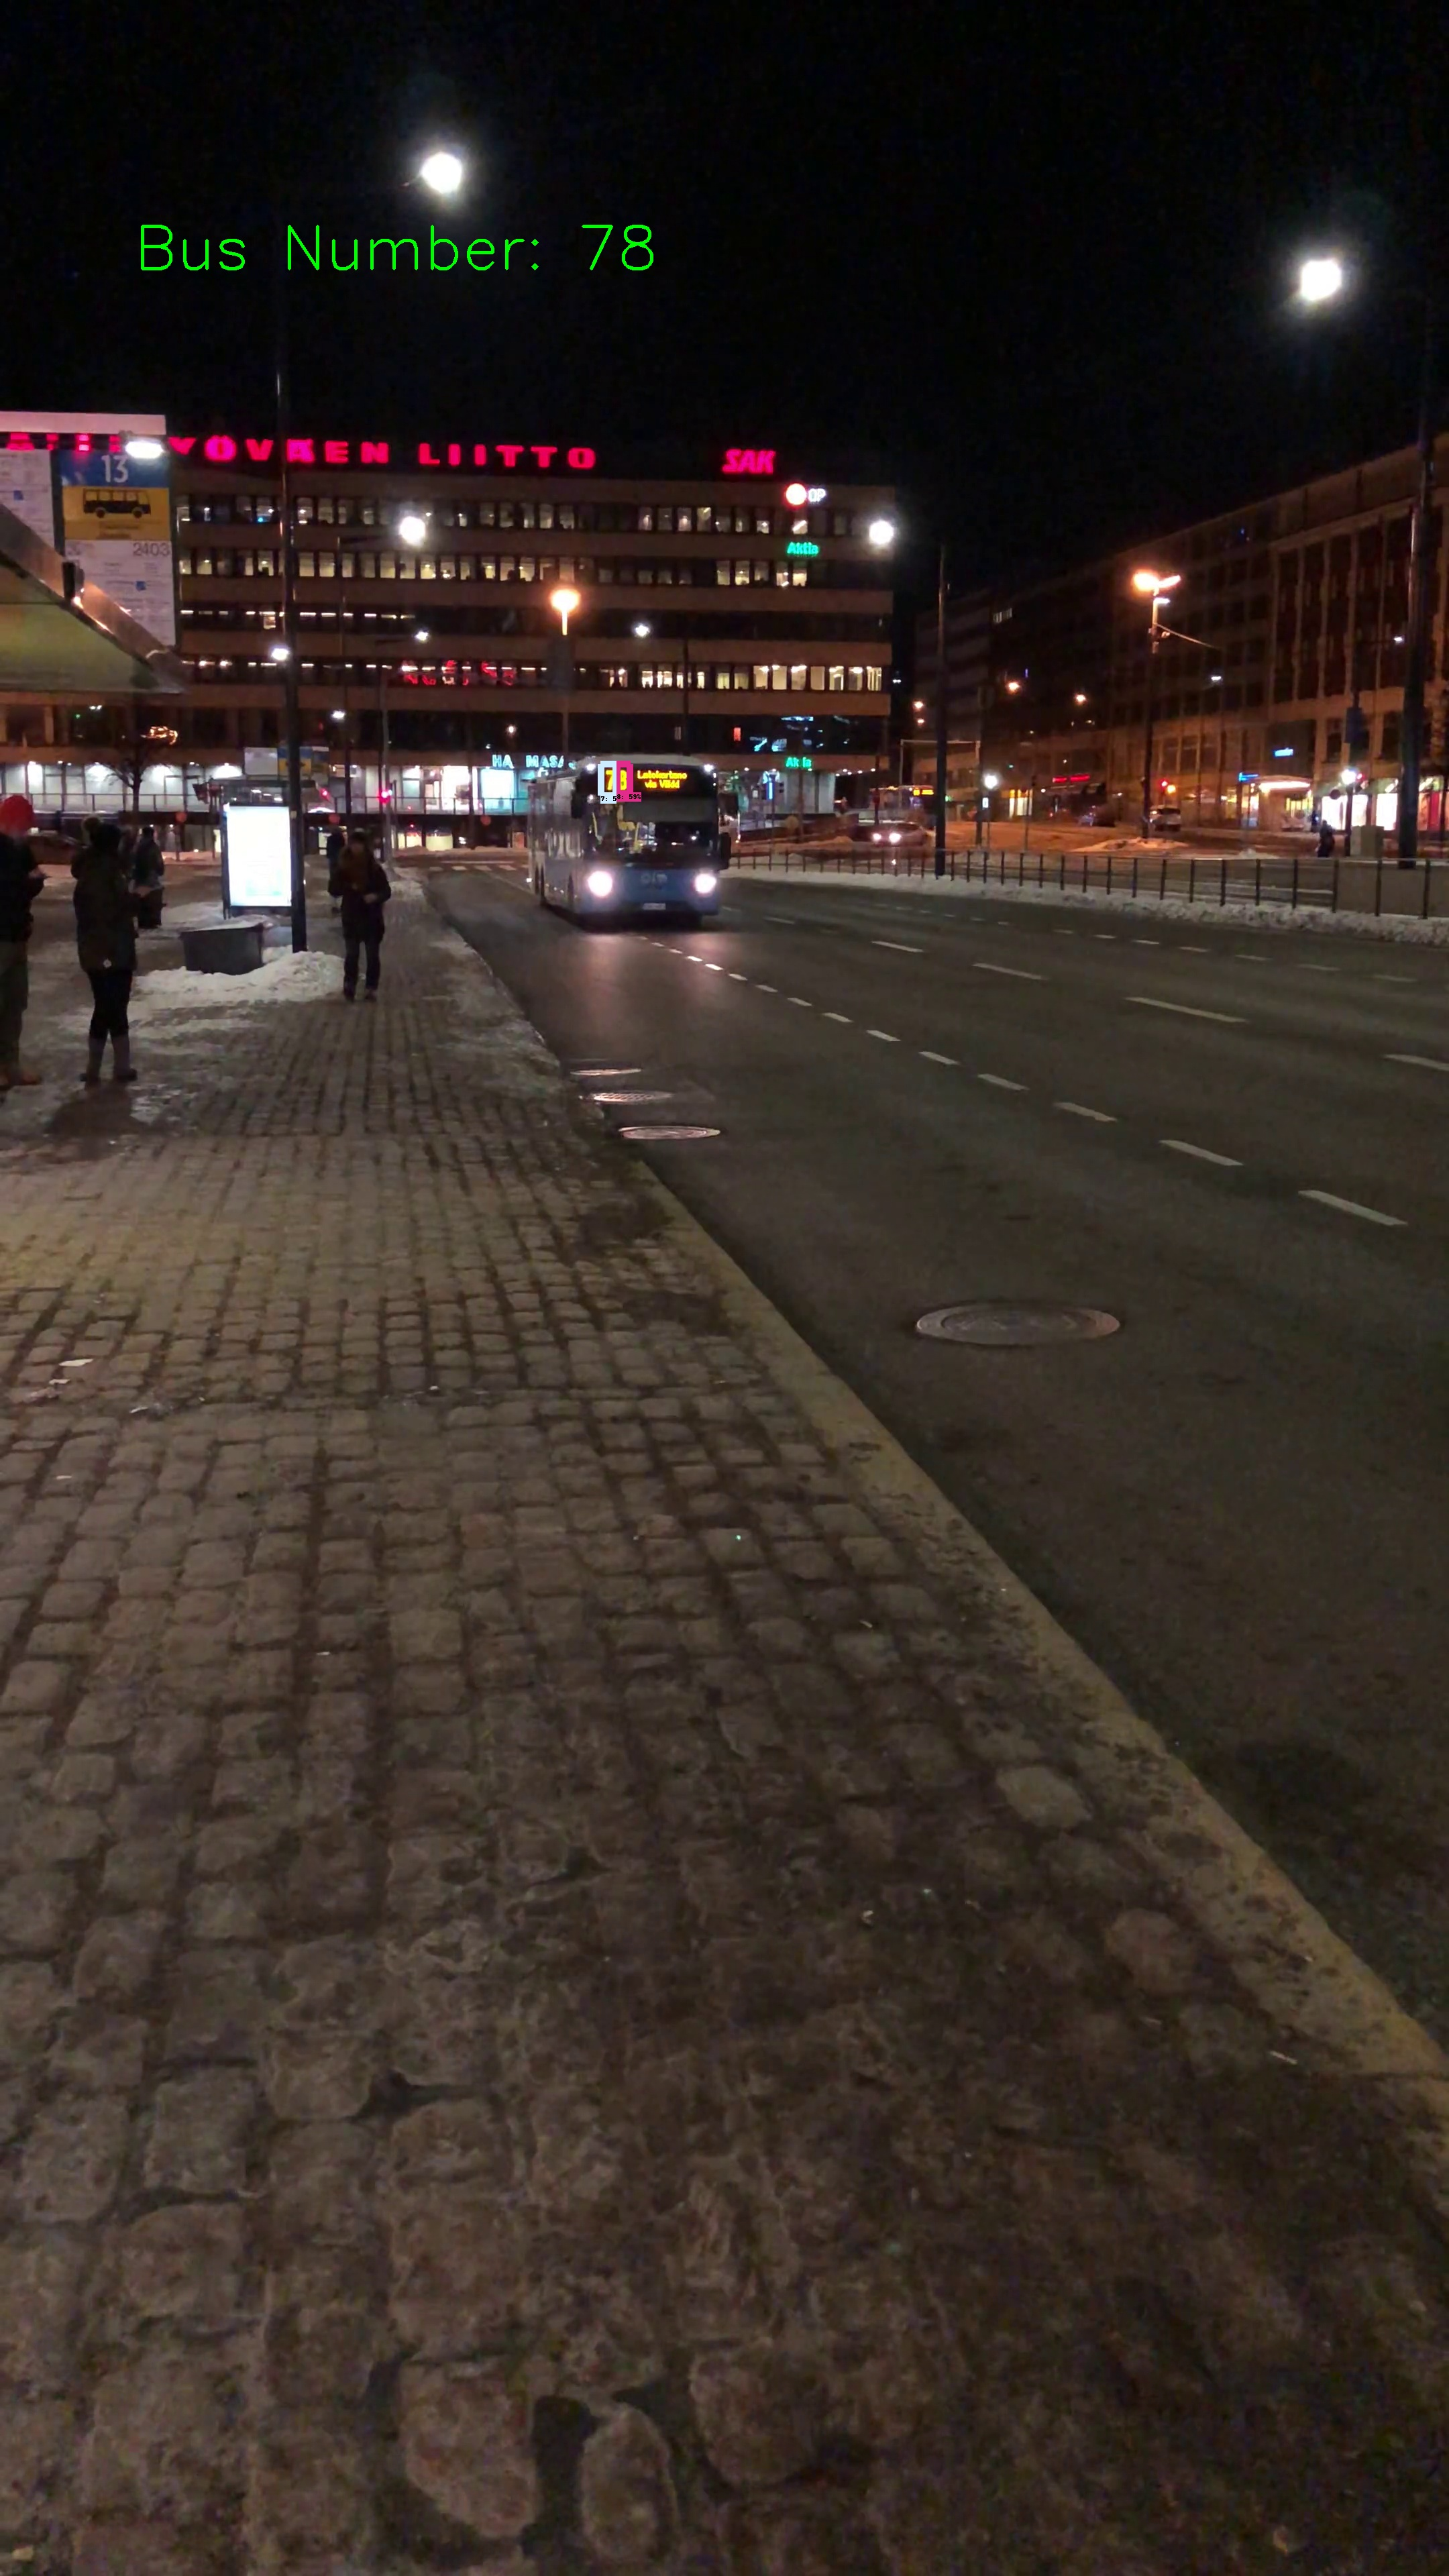

In [0]:
from IPython.display import Image
Image("output_image.jpg", width=700, height=1500)

## ***VIDEO WRITING***

In [0]:
import cv2
import gc

cap = cv2.VideoCapture(dir_path_main+'data/Training_3.MOV')

## Declare codec used 
### PLEASE CHANGE IF VIDEO IS NOT CODED PROPERLY
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
fh  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fw  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))


out = cv2.VideoWriter('Output-3-label-proper.avi',fourcc, 10, (fw,fh))


count = 0


# While there are more frames
while cap.isOpened():
    ret,frame = cap.read()
    print(ret)
    print(count)
    
    if ret:
      # Run Detection on one frame and write to video
      detected_digits ,labels = detect_bus_numbers(frame)
      output_image = add_bus_numbers(detected_digits,labels)
      out.write(output_image)

      cap.set(1, count)
      #Skipping one frame
      count = count + 2
      #collect garbage to make sure ram is not used up
      if count%50 ==0:
        gc.collect()
    else:
      cap.release()
      out.release()
      cv2.destroyAllWindows()

True
0
True
2
True
4
True
6
True
8
True
10
True
12
True
14
True
16
True
18
True
20
True
22
True
24
True
26
True
28
True
30
True
32
True
34
True
36
True
38
True
40
True
42
True
44
True
46
True
48
True
50
True
52
True
54
True
56
True
58
True
60
True
62
True
64
True
66
True
68
True
70
True
72
True
74
True
76
True
78
True
80
True
82
True
84
True
86
True
88
True
90
True
92
True
94
True
96
True
98
True
100
True
102
True
104
True
106
True
108
True
110
True
112
True
114
True
116
True
118
True
120
True
122
True
124
True
126
True
128
True
130
True
132
True
134
True
136
True
138
True
140
True
142
True
144
True
146
True
148
True
150
True
152
True
154
True
156
True
158
True
160
True
162
True
164
True
166
True
168
True
170
True
172
True
174
True
176
True
178
True
180
True
182
True
184
True
186
True
188
True
190
True
192
True
194
True
196
True
198
True
200
True
202
True
204
False
206



#Hardware specs and performance




In this project, I have used (2160x3840) pixel videos with an output rate of 6-8 fps.
I have implemented all the code on Google Colab, due to lack of my own GPU. </br>Here are the specs: </br>
* GPU: 1xTesla K80 , having 2496 CUDA cores, compute 3.7, 12GB(11.439GB Usable) GDDR5 VRAM.
* CPU: 1xsingle core hyper threaded i.e (1 core, 2 threads) Xeon Processors @2.3Ghz (No Turbo Boost) , 45MB Cache.

# Future Improvements

1. Merge overlapping bounding boxes of buses into one.  DONE
2. Multi Threading during the video processing.
3. Find a better way to reduce search space in the number_detection, than manual cropping.
4. Code for stabilizing bounding boxes.
